In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np

import math

from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 22})

/home/mojo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#!pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

In [3]:
np.random.seed(42)
torch.manual_seed(42)

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.25)

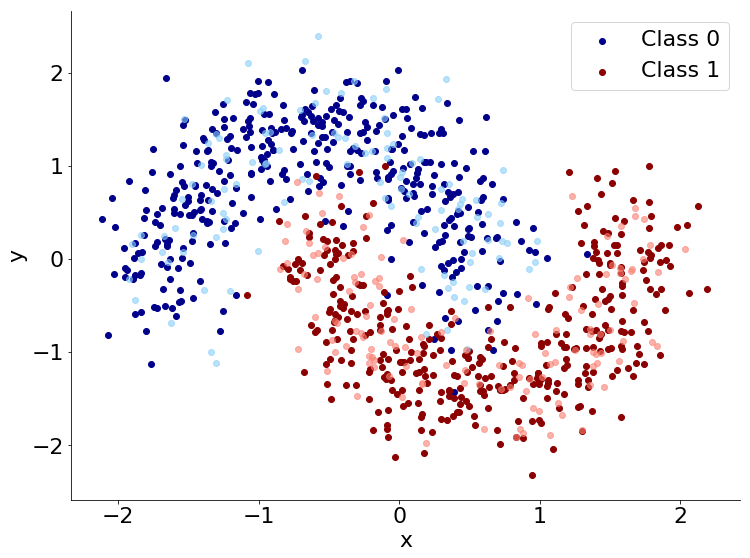

In [5]:
#sns.set(font_scale=1.75)
fig, ax = plt.subplots(figsize=(12,9),sharex='all',sharey='all')
#ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
#ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],color='darkblue', label='Class 0',alpha=1)
ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='darkred', label='Class 1',alpha=1)
#ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],color='dodgerblue',alpha=0.6)
#ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='red',alpha=0.6)
ax.scatter(X_val[y_val==0, 0], X_val[y_val==0, 1],color='lightskyblue',alpha=0.6)
ax.scatter(X_val[y_val==1, 0], X_val[y_val==1, 1], color='salmon',alpha=0.6)
#ax.set_facecolor("white")
sns.despine(); 
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')


matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rcParams.update({'axes.edgecolor': 'black'})

In [6]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).view(-1,1)

#X_test = torch.FloatTensor(X_test)
#y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=250, num_workers=0)
#test_data = torch.utils.data.TensorDataset(X_test, y_test)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=250)

In [126]:
y_val.size()

torch.Size([250, 1])

In [7]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = torch.FloatTensor(grid.reshape(2, -1).T)
dummy_out = torch.tensor(np.ones(grid_2d.shape))

In [123]:
dummy_out

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64)

In [8]:
test_data = torch.utils.data.TensorDataset(grid_2d, dummy_out)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(2, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [11]:
class evaluation(object):
    def __init__(self, test_data, criterion):
        self.test_data = test_data
        self.criterion = criterion
        self.n = 0.
        self.avg_prediction = 0.

    def acc(self, model):
        with torch.autograd.no_grad():
            self.n += 1
            for x,y in iter(self.test_data):
                x = x.view(x.size(0),-1)
                output = model(x)
                prediction = F.sigmoid(output)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + prediction / self.n
                loss = self.criterion(self.avg_prediction, y)
                acc = 100 * (torch.round(self.avg_prediction) == y.float()).float().sum() / x.size(0)

        return loss, acc

In [12]:


class sgld(object):
    def __init__(self, network, lr, lambda_, batch_size, dataset_size):
        self.network = network
        self.n = batch_size
        self.N = dataset_size
        self.linear_layers = [m for m in self.network.modules() if isinstance (m, nn.Linear)]
        self.lr_init = lr
        self.lambda_ = lambda_
        self.t = 1.





    def step(self,):
        learning_rate = self.lr_init * 0.5 ** (self.t // 3000)
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((prior_grad, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n
            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)
            noise = torch.randn_like(posterior_grad) * math.sqrt(learning_rate)
            update = (learning_rate * posterior_grad).add_(noise)

            if l.bias is not None:
                l.weight.data.add_(-update[:, :-1])
                l.bias.data.add_(-update[:, -1])
            else:
                l.weight.data.add_(-update)
        self.t +=1

In [71]:
np.random.seed(42)
torch.manual_seed(42)



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
# learning_rates = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
#learning_rates = [1e-3]
#learning_rates = [5e-5]
learning_rates = [3e-4]


batch_size = 32
dataset_size= 750.

n_samples = 200
predictions = torch.zeros(10000,n_samples)

# grid_search = True
grid_search = False

acc_sgld = []
loss_sgld = []

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.BCEWithLogitsLoss(size_average=False)

    optim = sgld(network, lr, lambda_, batch_size, dataset_size)

    evaluate = evaluation(val_loader, criterion)


    t = 1.
    n = 0
    for epoch in range(200):


        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
      #one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

            network.zero_grad()
            output = network(x)
            loss = criterion(output,y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 10 == 0) & (n < n_samples):
                accuracy = 0
                if grid_search:
                    bin_loss, acc = evaluate.acc(network)
                    n =+ 1
                else:
                    with torch.autograd.no_grad():
                        for x, y in iter(test_loader):
                            output = network(x)
                            output = F.sigmoid(output)
                            #prediction = output.data.max(1)[1].view(-1,1)
                            #print(prediction)

                        predictions[:,n] = output.view(-1,)
                n += 1


            t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
#     acc_sgld.append(acc)
#     loss_sgld.append(bin_loss)

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 10.1946
Epoch 1 - loss: 9.2719
Epoch 2 - loss: 9.2108
Epoch 3 - loss: 8.8437
Epoch 4 - loss: 8.6626
Epoch 5 - loss: 12.2042
Epoch 6 - loss: 7.0967
Epoch 7 - loss: 5.5082
Epoch 8 - loss: 5.0099
Epoch 9 - loss: 6.0568
Epoch 10 - loss: 7.2194
Epoch 11 - loss: 5.5124


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 12 - loss: 4.8250
Epoch 13 - loss: 4.8452
Epoch 14 - loss: 6.2901
Epoch 15 - loss: 4.6026
Epoch 16 - loss: 5.0015
Epoch 17 - loss: 5.1938
Epoch 18 - loss: 4.9180
Epoch 19 - loss: 4.1175
Epoch 20 - loss: 4.9090
Epoch 21 - loss: 6.9089
Epoch 22 - loss: 6.5087
Epoch 23 - loss: 4.1487
Epoch 24 - loss: 5.4986
Epoch 25 - loss: 5.1258
Epoch 26 - loss: 3.8698
Epoch 27 - loss: 4.3999
Epoch 28 - loss: 9.0183
Epoch 29 - loss: 8.7145
Epoch 30 - loss: 4.5206
Epoch 31 - loss: 4.3104
Epoch 32 - loss: 5.7390
Epoch 33 - loss: 5.1837
Epoch 34 - loss: 4.3444
Epoch 35 - loss: 4.4794
Epoch 36 - loss: 5.4573
Epoch 37 - loss: 4.7154
Epoch 38 - loss: 4.9939
Epoch 39 - loss: 4.6068
Epoch 40 - loss: 7.1852
Epoch 41 - loss: 4.2852
Epoch 42 - loss: 4.7767
Epoch 43 - loss: 3.8628
Epoch 44 - loss: 4.1700
Epoch 45 - loss: 5.6513
Epoch 46 - loss: 3.8059
Epoch 47 - loss: 3.6702
Epoch 48 - loss: 5.0672
Epoch 49 - loss: 9.7011
Epoch 50 - loss: 4.7275
Epoch 51 - loss: 4.3312
Epoch 52 - loss: 3.7935
Epoch 53 - loss:

In [117]:
loss_sgld

[tensor(9943.3076)]

In [70]:
acc_sgld

[tensor(42.),
 tensor(42.),
 tensor(42.),
 tensor(42.),
 tensor(42.),
 tensor(95.6000),
 tensor(96.),
 tensor(95.6000),
 tensor(96.),
 tensor(95.2000),
 tensor(96.),
 tensor(96.),
 tensor(96.),
 tensor(95.2000),
 tensor(95.6000),
 tensor(96.),
 tensor(94.8000),
 tensor(90.4000)]

Text(0.5,1,'SGLD')

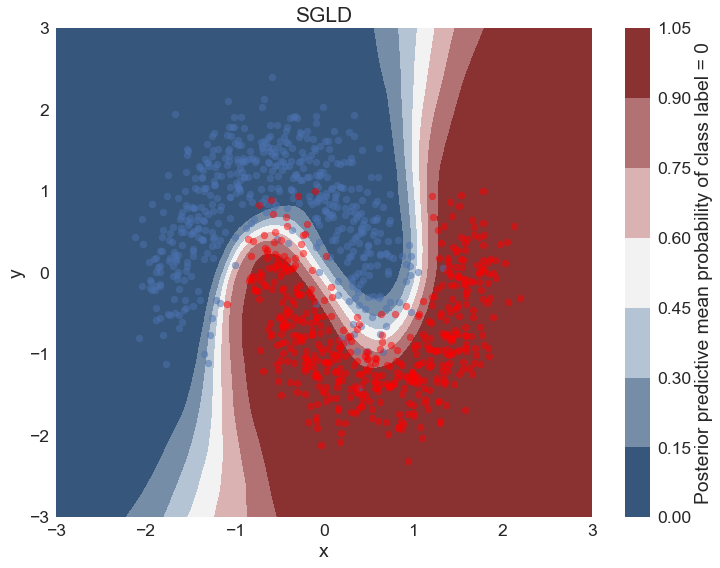

In [72]:
sns.set(font_scale=1.75)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
#ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
#ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.title('SGLD')

Text(0.5,1,'SGLD')

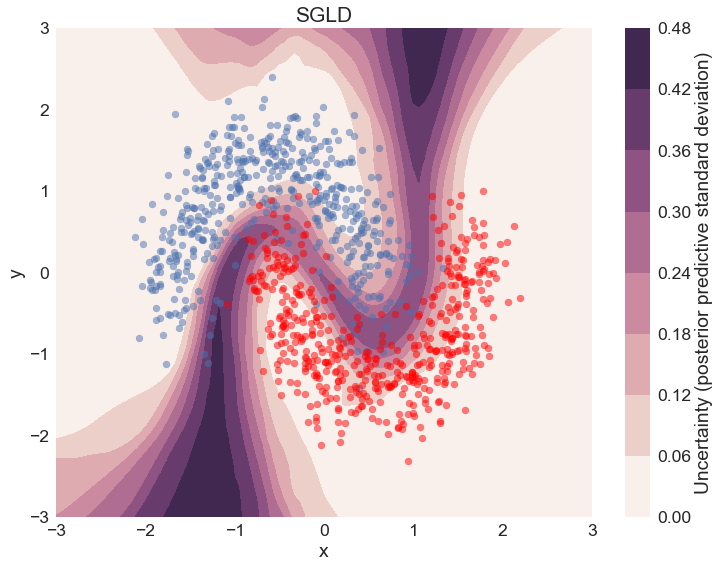

In [73]:
sns.set(font_scale=1.75)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
#ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
#ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');
matplotlib.rcParams.update({'font.size': 22})
plt.title('SGLD')

In [26]:
class psgld(object):
    ### pSGLD with RMSProp as preconditioner

    def __init__(self, network, lr, alpha, lambda_, batch_size, dataset_size):
        self.network = network
        self.n = batch_size
        self.N = dataset_size
        self.linear_layers = [m for m in self.network.modules() if isinstance (m, nn.Linear)]
        self.lr_init = lr
        self.alpha = alpha
        self.lambda_ = lambda_
        self.t = 1.

        self.square_avg = dict()

    def step(self,):
        learning_rate = self.lr_init * 0.5 ** (self.t // 3000)
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                likelihood_grad = torch.cat((likelihood_grad, l.bias.grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((prior_grad, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)

            if self.t == 1:
                self.square_avg[l] = torch.zeros_like(posterior_grad)

            self.square_avg[l].mul_(self.alpha).addcmul_(1. - self.alpha, likelihood_grad, likelihood_grad)
            avg = self.square_avg[l].sqrt().add_(1e-8)
            noise = torch.randn_like(posterior_grad)


            update = (learning_rate * 0.5 * torch.div(posterior_grad, avg)).addcdiv_(math.sqrt(learning_rate), noise, avg.sqrt())


            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)

        self.t +=1

In [66]:
np.random.seed(42)
torch.manual_seed(42)



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [9e-3, 8e-3, 7e-3, 6e-3, 5e-3, 4e-3, 3e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4]
#learning_rates = [1e-3]
#learning_rates = [5e-5]
#learning_rates = [6e-4]


batch_size = 32
dataset_size= 750.

alpha = 0.99

n_samples = 200
predictions = torch.zeros(10000,n_samples)

grid_search = True
#grid_search = False

acc_psgld = []
loss_psgld = []

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.BCEWithLogitsLoss(size_average=False)

    optim = psgld(network, lr, alpha, lambda_, batch_size, dataset_size)

    evaluate = evaluation(val_loader, criterion)


    t = 1.
    n = 0
    for epoch in range(200):


        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
      #one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

            network.zero_grad()
            output = network(x)
            loss = criterion(output,y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 10 == 0) & (n < n_samples):
                accuracy = 0
                if grid_search:
                    bin_loss, acc = evaluate.acc(network)
                    n =+ 1
                else:
                    with torch.autograd.no_grad():
                        for x, y in iter(test_loader):
                            output = network(x)
                            output = F.sigmoid(output)
                            #prediction = output.data.max(1)[1].view(-1,1)
                            #print(prediction)

                            predictions[:,n] = output.view(-1,)
                        n += 1


            t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    acc_psgld.append(acc)
    loss_psgld.append(bin_loss)

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 37203.4492
Epoch 1 - loss: 3971.5056
Epoch 2 - loss: 1677.7404
Epoch 3 - loss: 853.5843
Epoch 4 - loss: 1078.2629
Epoch 5 - loss: 843.6100
Epoch 6 - loss: 811.0742
Epoch 7 - loss: 1447.3188
Epoch 8 - loss: 758.4530
Epoch 9 - loss: 1070.0529
Epoch 10 - loss: 557.6868
Epoch 11 - loss: 398.3591
Epoch 12 - loss: 753.7991
Epoch 13 - loss: 472.3863


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 14 - loss: 389.8458
Epoch 15 - loss: 404.6418
Epoch 16 - loss: 362.9722
Epoch 17 - loss: 522.6559
Epoch 18 - loss: 350.7457
Epoch 19 - loss: 202.2610
Epoch 20 - loss: 291.7751
Epoch 21 - loss: 169.9383
Epoch 22 - loss: 174.4252
Epoch 23 - loss: 166.6564
Epoch 24 - loss: 158.1692
Epoch 25 - loss: 136.4691
Epoch 26 - loss: 295.0868
Epoch 27 - loss: 91.3358
Epoch 28 - loss: 125.7289
Epoch 29 - loss: 117.5245
Epoch 30 - loss: 71.5544
Epoch 31 - loss: 86.0850
Epoch 32 - loss: 756.3823
Epoch 33 - loss: 103.6795
Epoch 34 - loss: 64.5112
Epoch 35 - loss: 43.8359
Epoch 36 - loss: 49.1832
Epoch 37 - loss: 54.2619
Epoch 38 - loss: 332.5230
Epoch 39 - loss: 54.8034
Epoch 40 - loss: 21.4191
Epoch 41 - loss: 15.7750
Epoch 42 - loss: 19.0264
Epoch 43 - loss: 14.1036
Epoch 44 - loss: 61.6743
Epoch 45 - loss: 11.8645
Epoch 46 - loss: 30.2210
Epoch 47 - loss: 5.5203
Epoch 48 - loss: 7.3121
Epoch 49 - loss: 11.8937
Epoch 50 - loss: 6.5566
Epoch 51 - loss: 4.8054
Epoch 52 - loss: 173.5434
Epoch 53 -

Epoch 144 - loss: 4.1483
Epoch 145 - loss: 3.6732
Epoch 146 - loss: 4.5877
Epoch 147 - loss: 3.6248
Epoch 148 - loss: 3.3815
Epoch 149 - loss: 4.1869
Epoch 150 - loss: 4.3954
Epoch 151 - loss: 4.3450
Epoch 152 - loss: 3.3840
Epoch 153 - loss: 4.4485
Epoch 154 - loss: 4.1027
Epoch 155 - loss: 3.4598
Epoch 156 - loss: 4.9780
Epoch 157 - loss: 3.2602
Epoch 158 - loss: 3.9241
Epoch 159 - loss: 4.2920
Epoch 160 - loss: 3.8055
Epoch 161 - loss: 3.7228
Epoch 162 - loss: 3.5406
Epoch 163 - loss: 4.2675
Epoch 164 - loss: 3.9778
Epoch 165 - loss: 4.0842
Epoch 166 - loss: 5.9210
Epoch 167 - loss: 8.3448
Epoch 168 - loss: 4.3241
Epoch 169 - loss: 3.6493
Epoch 170 - loss: 3.4350
Epoch 171 - loss: 3.5114
Epoch 172 - loss: 3.6459
Epoch 173 - loss: 4.6794
Epoch 174 - loss: 4.8484
Epoch 175 - loss: 3.6862
Epoch 176 - loss: 4.1728
Epoch 177 - loss: 4.1109
Epoch 178 - loss: 4.5240
Epoch 179 - loss: 4.7502
Epoch 180 - loss: 4.2690
Epoch 181 - loss: 4.2068
Epoch 182 - loss: 5.8488
Epoch 183 - loss: 3.9144


Epoch 80 - loss: 7.0564
Epoch 81 - loss: 7.1735
Epoch 82 - loss: 7.1878
Epoch 83 - loss: 7.1889
Epoch 84 - loss: 7.0611
Epoch 85 - loss: 7.0251
Epoch 86 - loss: 7.0981
Epoch 87 - loss: 7.1370
Epoch 88 - loss: 6.9889
Epoch 89 - loss: 6.8994
Epoch 90 - loss: 6.9126
Epoch 91 - loss: 6.9269
Epoch 92 - loss: 7.0232
Epoch 93 - loss: 7.0556
Epoch 94 - loss: 7.0974
Epoch 95 - loss: 7.2133
Epoch 96 - loss: 7.0796
Epoch 97 - loss: 7.0041
Epoch 98 - loss: 6.9540
Epoch 99 - loss: 6.7156
Epoch 100 - loss: 6.6518
Epoch 101 - loss: 6.4472
Epoch 102 - loss: 6.3584
Epoch 103 - loss: 6.3588
Epoch 104 - loss: 6.4318
Epoch 105 - loss: 6.4123
Epoch 106 - loss: 6.3871
Epoch 107 - loss: 6.3916
Epoch 108 - loss: 6.3987
Epoch 109 - loss: 6.2652
Epoch 110 - loss: 6.2376
Epoch 111 - loss: 6.0752
Epoch 112 - loss: 6.0778
Epoch 113 - loss: 5.9294
Epoch 114 - loss: 5.8345
Epoch 115 - loss: 5.7433
Epoch 116 - loss: 5.6926
Epoch 117 - loss: 5.7064
Epoch 118 - loss: 5.8430
Epoch 119 - loss: 5.7816
Epoch 120 - loss: 5.

Epoch 9 - loss: 22.0223
Epoch 10 - loss: 22.0287
Epoch 11 - loss: 22.0756
Epoch 12 - loss: 22.0500
Epoch 13 - loss: 22.0160
Epoch 14 - loss: 22.0267
Epoch 15 - loss: 22.0162
Epoch 16 - loss: 22.0488
Epoch 17 - loss: 22.0843
Epoch 18 - loss: 22.0754
Epoch 19 - loss: 22.1166
Epoch 20 - loss: 22.1084
Epoch 21 - loss: 22.1348
Epoch 22 - loss: 22.1249
Epoch 23 - loss: 22.1039
Epoch 24 - loss: 22.0874
Epoch 25 - loss: 22.0423
Epoch 26 - loss: 22.0048
Epoch 27 - loss: 21.9750
Epoch 28 - loss: 21.9116
Epoch 29 - loss: 21.9008
Epoch 30 - loss: 21.8711
Epoch 31 - loss: 21.8395
Epoch 32 - loss: 21.7955
Epoch 33 - loss: 21.7505
Epoch 34 - loss: 21.7223
Epoch 35 - loss: 21.6989
Epoch 36 - loss: 21.6948
Epoch 37 - loss: 21.6524
Epoch 38 - loss: 21.6332
Epoch 39 - loss: 21.6217
Epoch 40 - loss: 21.5956
Epoch 41 - loss: 21.6157
Epoch 42 - loss: 21.6284
Epoch 43 - loss: 21.6180
Epoch 44 - loss: 21.6515
Epoch 45 - loss: 21.6683
Epoch 46 - loss: 21.6249
Epoch 47 - loss: 21.5722
Epoch 48 - loss: 21.5817
E

Epoch 132 - loss: 20.7459
Epoch 133 - loss: 20.7333
Epoch 134 - loss: 20.7251
Epoch 135 - loss: 20.7319
Epoch 136 - loss: 20.7482
Epoch 137 - loss: 20.7421
Epoch 138 - loss: 20.7431
Epoch 139 - loss: 20.7436
Epoch 140 - loss: 20.7532
Epoch 141 - loss: 20.7713
Epoch 142 - loss: 20.7795
Epoch 143 - loss: 20.7773
Epoch 144 - loss: 20.7809
Epoch 145 - loss: 20.7844
Epoch 146 - loss: 20.7842
Epoch 147 - loss: 20.7780
Epoch 148 - loss: 20.7864
Epoch 149 - loss: 20.7940
Epoch 150 - loss: 20.7960
Epoch 151 - loss: 20.7997
Epoch 152 - loss: 20.8003
Epoch 153 - loss: 20.7990
Epoch 154 - loss: 20.8000
Epoch 155 - loss: 20.8135
Epoch 156 - loss: 20.8033
Epoch 157 - loss: 20.7968
Epoch 158 - loss: 20.7998
Epoch 159 - loss: 20.7922
Epoch 160 - loss: 20.7794
Epoch 161 - loss: 20.7773
Epoch 162 - loss: 20.7672
Epoch 163 - loss: 20.7711
Epoch 164 - loss: 20.7824
Epoch 165 - loss: 20.7834
Epoch 166 - loss: 20.7837
Epoch 167 - loss: 20.7902
Epoch 168 - loss: 20.7935
Epoch 169 - loss: 20.7985
Epoch 170 - 

Epoch 54 - loss: 19.3418
Epoch 55 - loss: 19.3412
Epoch 56 - loss: 19.3415
Epoch 57 - loss: 19.3413
Epoch 58 - loss: 19.3411
Epoch 59 - loss: 19.3420
Epoch 60 - loss: 19.3417
Epoch 61 - loss: 19.3428
Epoch 62 - loss: 19.3424
Epoch 63 - loss: 19.3433
Epoch 64 - loss: 19.3450
Epoch 65 - loss: 19.3455
Epoch 66 - loss: 19.3450
Epoch 67 - loss: 19.3437
Epoch 68 - loss: 19.3448
Epoch 69 - loss: 19.3463
Epoch 70 - loss: 19.3473
Epoch 71 - loss: 19.3487
Epoch 72 - loss: 19.3488
Epoch 73 - loss: 19.3477
Epoch 74 - loss: 19.3476
Epoch 75 - loss: 19.3480
Epoch 76 - loss: 19.3466
Epoch 77 - loss: 19.3457
Epoch 78 - loss: 19.3459
Epoch 79 - loss: 19.3438
Epoch 80 - loss: 19.3421
Epoch 81 - loss: 19.3403
Epoch 82 - loss: 19.3385
Epoch 83 - loss: 19.3387
Epoch 84 - loss: 19.3378
Epoch 85 - loss: 19.3366
Epoch 86 - loss: 19.3383
Epoch 87 - loss: 19.3392
Epoch 88 - loss: 19.3391
Epoch 89 - loss: 19.3392
Epoch 90 - loss: 19.3400
Epoch 91 - loss: 19.3387
Epoch 92 - loss: 19.3391
Epoch 93 - loss: 19.3387


In [41]:
loss_psgld

[tensor(137.8353),
 tensor(128.9832),
 tensor(128.7973),
 tensor(140.1629),
 tensor(156.4238),
 tensor(173.3073),
 tensor(175.0963),
 tensor(179.9761),
 tensor(171.0098)]

In [62]:
acc_psgld

[tensor(95.6000),
 tensor(95.6000),
 tensor(95.6000),
 tensor(95.6000),
 tensor(94.8000),
 tensor(95.6000),
 tensor(96.),
 tensor(96.),
 tensor(96.4000),
 tensor(96.),
 tensor(96.),
 tensor(95.6000),
 tensor(96.4000),
 tensor(96.4000),
 tensor(96.4000),
 tensor(95.6000),
 tensor(94.4000),
 tensor(89.6000)]

Text(0.5,1,'pSGLD')

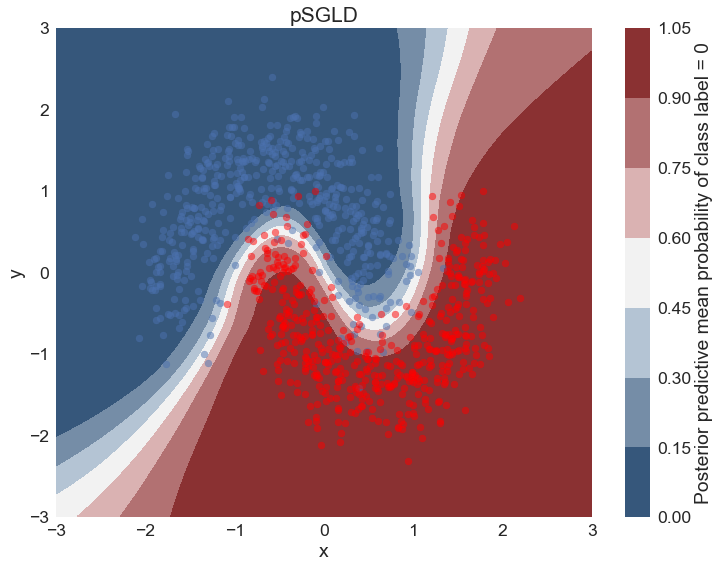

In [64]:
sns.set(font_scale=1.75)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.title('pSGLD')

Text(0.5,1,'pSGLD')

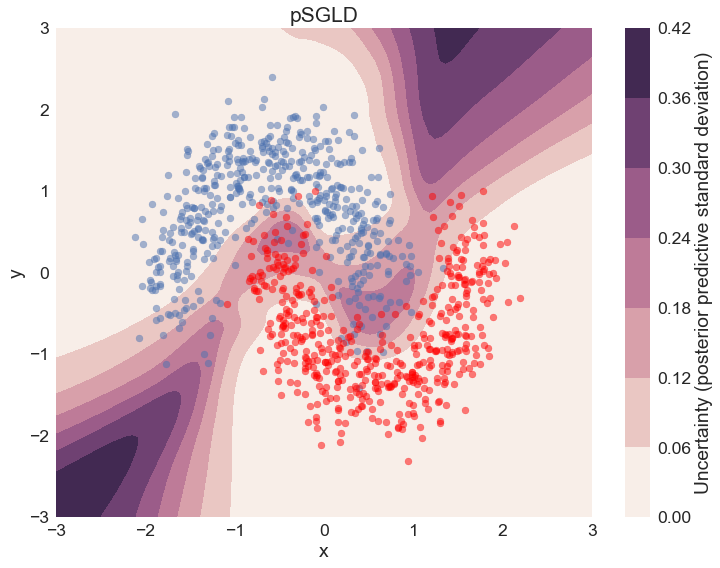

In [65]:
sns.set(font_scale=1.75)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');
plt.title('pSGLD')

In [31]:
from enum import Enum

import scipy.linalg as la



class BackpropMode(Enum):
    STANDARD = 0
    CURVATURE = 1


class KSGFS(object):

    def __init__(self, net, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-3, epsilon=1e-3, l2=1e-3, invert_every=1):
        if not isinstance(criterion, (nn.CrossEntropyLoss, nn.BCEWithLogitsLoss, nn.MSELoss)):
            raise ValueError("Unrecognized loss:", criterion.__class__.__name__)


        self.net = net
        self.criterion = criterion
        self.invert_every = invert_every
        self.inversion_counter = -1


        self.n = batch_size
        self.N = dataset_size
        self.gamma = float(dataset_size + batch_size) / batch_size
        # self.learning_rate = 2. / (self.gamma * (float(self.N)/self.n + 4. / (self.n *epsilon)))
        # self.learning_rate = 2. / (self.gamma * (float(self.N) / self.n + 4. / (self.n * epsilon)))
        self.learning_rate = 2. / (self.gamma * (float(self.N) / self.n  + 4. / (self.n * epsilon)))
        # self.noise_factor = 2. * math.sqrt(self.gamma / (epsilon * self.N))
        # self.noise_factor = 2. * math.sqrt(1. / (epsilon * self.N))
        # self.noise_factor = 2. * math.sqrt(self.gamma / (self.n * epsilon))
        # self.noise_factor = 2. * math.sqrt((self.gamma * float(self.N) / self.n) / epsilon) 
        self.noise_factor = 2. * math.sqrt(self.gamma / (self.n * epsilon))

        self.eta = eta
        self.v = v
        self.lambda_ = lambda_
        self.l2 = l2
        self.epsilon = epsilon

        self.mode = BackpropMode.STANDARD

        self.linear_layers = [m for m in self.net.modules() if isinstance(m, nn.Linear)]

        self.input_covariances = dict()
        self.preactivation_fishers = dict()
        self.preactivations = dict()
        self.preactivation_fisher_inverses = dict()
        self.input_covariance_inverses = dict()

        self.t = 1.

        self._add_hooks_to_net()

    def update_curvature(self, x):
        self.mode = BackpropMode.CURVATURE

        output = self.net(x)
        preacts = [self.preactivations[l] for l in self.linear_layers]
        if isinstance(self.criterion, nn.CrossEntropyLoss):
            p = F.softmax(output, 1).detach()
            label_sample = torch.multinomial(p, 1, out=p.new(p.size(0)).long()).squeeze()
            loss_fun = F.cross_entropy
        elif isinstance(self.criterion, nn.MSELoss):
            p = output.detach()
            label_sample = torch.normal(p, 1.)
            loss_fun = lambda x, y, **kwargs: 0.5 * F.mse_loss(x, y, **kwargs).sum(1)
        elif isinstance(self.criterion, nn.BCEWithLogitsLoss):
            p = output.detach()
#            label_sample = torch.bernoulli(p, out=p.new(p.size()))
            p = F.sigmoid(p)
            label_sample = torch.bernoulli(p)
            loss_fun = lambda x, y, **kwargs: F.binary_cross_entropy_with_logits(x, y, **kwargs).sum(1)
        else:
            raise NotImplemented

        l = sum(loss_fun(output, label_sample, reduce=False))
        preact_grads = torch.autograd.grad(l, preacts)
        scale = p.size(0) ** -1
        for pg, mod in zip(preact_grads, self.linear_layers):
            preact_fisher = pg.t().mm(pg).detach() * scale
            self._update_factor(self.preactivation_fishers, mod, preact_fisher)

        self.mode = BackpropMode.STANDARD

        self.inversion_counter += 1
        if self.inversion_counter % self.invert_every == 0:
            self.inversion_counter = 0
            self.invert_curvature()

    def invert_curvature(self):
        self._invert_fn(self.preactivation_fishers, self.preactivation_fisher_inverses)
        self._invert_fn(self.input_covariances, self.input_covariance_inverses)

    def _invert_fn(self, d, inv_dict):
        for mod, mat in d.items():
            l, u = map(mat.new, la.eigh(mat.numpy()))

            inv = (u * ((l + self.lambda_) ** -1)).mm(u.t())
            inv_dict[mod] = inv

    def _linear_forward_hook(self, mod, inputs, output):
        if self.mode == BackpropMode.CURVATURE:
            self.preactivations[mod] = output
            inp = inputs[0]
            scale = output.size(0) ** -1
            if mod.bias is not None:
                inp = torch.cat((inp, inp.new(inp.size(0), 1).fill_(1)), 1)
            input_cov = inp.t().mm(inp).detach() * scale
            self._update_factor(self.input_covariances, mod, input_cov)

    def _update_factor(self, d, mod, mat):
        if mod not in d or (self.v == 0 and self.eta == 1):
            d[mod] = mat
        else:
            d[mod] = self.v * d[mod] + self.eta * mat

    def step(self, closure=None):
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((l.weight.data, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            # posterior_grad = likelihood_grad.add((self.lambda_ / self.N) , prior_grad)
            posterior_grad = likelihood_grad.add(self.lambda_ , prior_grad)

            noise = torch.randn_like(posterior_grad)

            # Small epsilon to stabilise computation of Cholesky factors
            eps = 1e-5
            A_ch = torch.potrf(self.input_covariances[l].add(eps, torch.eye(noise.size(1))))
            G_ch = torch.potrf(self.preactivation_fishers[l].add(eps, torch.eye(noise.size(0))), upper=False)
            noise_precon = G_ch.mm(noise).mm(A_ch)

            posterior_grad.add_(self.noise_factor, noise_precon)

            A_inv = self.input_covariance_inverses[l]
            G_inv = self.preactivation_fisher_inverses[l]
            update = self.learning_rate * G_inv.mm(posterior_grad).mm(A_inv)

            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)
        self.t += 1

    def _add_hooks_to_net(self):
        def register_hook(m):
            if isinstance(m, nn.Linear):
                m.register_forward_hook(self._linear_forward_hook)

        self.net.apply(register_hook)

In [110]:
np.random.seed(42)
torch.manual_seed(42)



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")




# learning_rates = [1e-1, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
learning_rates = [1e-1, 8e-2, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2]
#learning_rates = [1e-3]
#learning_rates = [5e-5]
learning_rates = [1e-1]

v = 0.
l2 = 1e-3
lambda_ = 1.
eta = 1.


batch_size = 32
dataset_size= 750.

n_samples = 200
predictions = torch.zeros(10000,n_samples)

#grid_search = True
grid_search = False

acc_ksgfs = []
loss_ksgfs = []

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.BCEWithLogitsLoss(size_average=False)

    optim = KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)

    evaluate = evaluation(val_loader, criterion)


    t = 1.
    n = 0
    for epoch in range(200):


        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
      #one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = criterion(output,y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 10 == 0) & (n < n_samples):
                accuracy = 0
                if grid_search:
                    bin_loss, acc = evaluate.acc(network)
                    n =+ 1
                else:
                    with torch.autograd.no_grad():
                        for x, y in iter(test_loader):
                            output = network(x)
                            output = F.sigmoid(output)
                            #prediction = output.data.max(1)[1].view(-1,1)
                            #print(prediction)

                        predictions[:,n] = output.view(-1,)
                n += 1


            t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    acc_ksgfs.append(acc)
    loss_ksgfs.append(bin_loss)


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 9.9758
Epoch 1 - loss: 9.7879
Epoch 2 - loss: 7.0568
Epoch 3 - loss: 14.3440
Epoch 4 - loss: 7.3455
Epoch 5 - loss: 11.6360
Epoch 6 - loss: 8.7122
Epoch 7 - loss: 4.9063
Epoch 8 - loss: 6.3116
Epoch 9 - loss: 5.8633
Epoch 10 - loss: 5.4473
Epoch 11 - loss: 11.2853
Epoch 12 - loss: 10.1375
Epoch 13 - loss: 3.7082
Epoch 14 - loss: 3.9391
Epoch 15 - loss: 3.6799
Epoch 16 - loss: 3.9137
Epoch 17 - loss: 4.3287
Epoch 18 - loss: 4.3710
Epoch 19 - loss: 5.5234
Epoch 20 - loss: 4.3773
Epoch 21 - loss: 4.4542
Epoch 22 - loss: 4.5080
Epoch 23 - loss: 4.0886
Epoch 24 - loss: 3.4577
Epoch 25 - loss: 4.2159
Epoch 26 - loss: 5.9875
Epoch 27 - loss: 4.6681
Epoch 28 - loss: 4.1477
Epoch 29 - loss: 4.4468
Epoch 30 - loss: 4.4924
Epoch 31 - loss: 4.1688
Epoch 32 - loss: 3.8904
Epoch 33 - loss: 4.7180
Epoch 34 - loss: 4.1579
Epoch 35 - loss: 4.4860
Epoch 36 - loss: 4.2812
Epoch 37 - loss: 4.2533
Epoch 38 - loss: 3.7712
Epoch 39 - loss: 5.2668
Epoch 40 - loss: 3.3973
Epoch 41 - loss: 3.405

In [35]:
acc_ksgfs

[tensor(96.4000),
 tensor(95.6000),
 tensor(96.),
 tensor(95.6000),
 tensor(81.6000),
 tensor(81.6000),
 tensor(64.8000),
 tensor(62.8000),
 tensor(33.2000)]

Text(0.5,1,'K-SGFS')

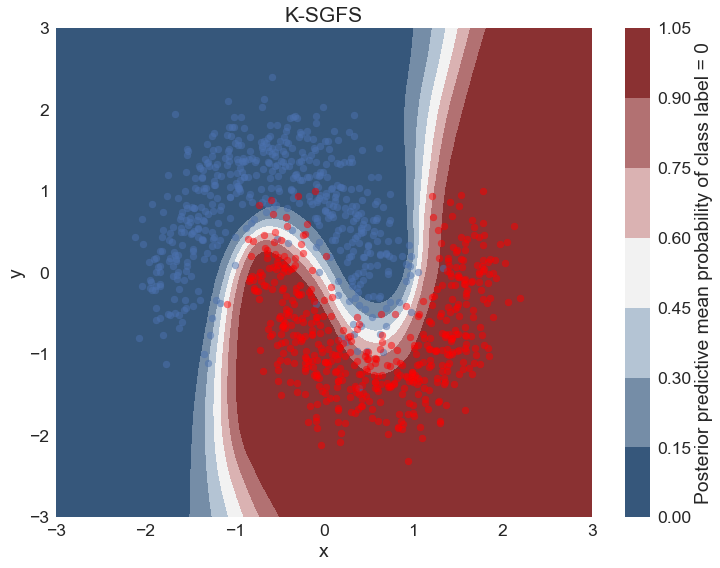

In [111]:
sns.set(font_scale=1.75)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.title('K-SGFS')

Text(0.5,1,'K-SGFS')

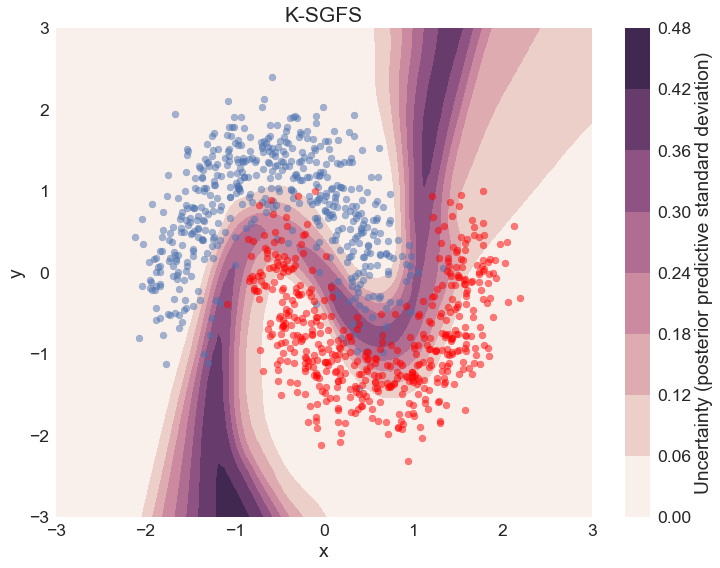

In [112]:
sns.set(font_scale=1.75)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');
plt.title('K-SGFS')

In [84]:


class BackpropMode(Enum):
    STANDARD = 0
    CURVATURE = 1


class KSGLD(object):

    def __init__(self, net, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-3, epsilon=2., l2=1e-3, invert_every=1):
        if not isinstance(criterion, (nn.CrossEntropyLoss, nn.BCEWithLogitsLoss, nn.MSELoss)):
            raise ValueError("Unrecognized loss:", criterion.__class__.__name__)


        self.net = net
        self.criterion = criterion
        self.invert_every = invert_every
        self.inversion_counter = -1


        self.n = batch_size
        self.N = dataset_size
        self.epsilon= epsilon


        self.eta = eta
        self.v = v
        self.lambda_ = lambda_
        self.l2 = l2

        self.mode = BackpropMode.STANDARD

        self.linear_layers = [m for m in self.net.modules() if isinstance(m, nn.Linear)]

        self.input_covariances = dict()
        self.preactivation_fishers = dict()
        self.preactivations = dict()
        self.preactivation_fisher_inverses = dict()
        self.input_covariance_inverses = dict()

        self.t = 1.

        self._add_hooks_to_net()

    def update_curvature(self, x):
        self.mode = BackpropMode.CURVATURE

        output = self.net(x)
        preacts = [self.preactivations[l] for l in self.linear_layers]
        if isinstance(self.criterion, nn.CrossEntropyLoss):
            p = F.softmax(output, 1).detach()
            label_sample = torch.multinomial(p, 1, out=p.new(p.size(0)).long()).squeeze()
            loss_fun = F.cross_entropy
        elif isinstance(self.criterion, nn.MSELoss):
            p = output.detach()
            # label_sample = torch.bernoulli(p, out=p.new(p.size()))
            label_sample = torch.normal(p, 1.)
            loss_fun = lambda x, y, **kwargs: 0.5 * F.mse_loss(x, y, **kwargs).sum(1)
        elif isinstance(self.criterion, nn.BCEWithLogitsLoss):
            p = output.detach()
#            label_sample = torch.bernoulli(p, out=p.new(p.size()))
            p = F.sigmoid(p)
            label_sample = torch.bernoulli(p)
            loss_fun = lambda x, y, **kwargs: F.binary_cross_entropy_with_logits(x, y, **kwargs).sum(1)
        else:
            raise NotImplemented

        l = sum(loss_fun(output, label_sample, reduce=False))
        preact_grads = torch.autograd.grad(l, preacts)
        scale = p.size(0) ** -1
        for pg, mod in zip(preact_grads, self.linear_layers):
            preact_fisher = pg.t().mm(pg).detach() * scale
            self._update_factor(self.preactivation_fishers, mod, preact_fisher)

        self.mode = BackpropMode.STANDARD

        self.inversion_counter += 1
        if self.inversion_counter % self.invert_every == 0:
            self.inversion_counter = 0
            self.invert_curvature()

    def invert_curvature(self):
        self._invert_fn(self.preactivation_fishers, self.preactivation_fisher_inverses)
        self._invert_fn(self.input_covariances, self.input_covariance_inverses)

    def _invert_fn(self, d, inv_dict):
        for mod, mat in d.items():
            l, u = map(mat.new, la.eigh(mat.numpy()))

            inv = (u * ((l + self.lambda_) ** -1)).mm(u.t())
            inv_dict[mod] = inv

    def _linear_forward_hook(self, mod, inputs, output):
        if self.mode == BackpropMode.CURVATURE:
            self.preactivations[mod] = output
            inp = inputs[0]
            scale = output.size(0) ** -1
            if mod.bias is not None:
                inp = torch.cat((inp, inp.new(inp.size(0), 1).fill_(1)), 1)
            input_cov = inp.t().mm(inp).detach() * scale
            self._update_factor(self.input_covariances, mod, input_cov)

    def _update_factor(self, d, mod, mat):
        if mod not in d or (self.v == 0 and self.eta == 1):
            d[mod] = mat
        else:
            d[mod] = self.v * d[mod] + self.eta * mat

    def step(self, closure=None):
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((l.weight.data, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            # posterior_grad = likelihood_grad.add((self.lambda_ / self.N) , prior_grad)
            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)

            noise = torch.randn_like(posterior_grad)

            A_inv = self.input_covariance_inverses[l]
            G_inv = self.preactivation_fisher_inverses[l]

            nat_grad = G_inv.mm(posterior_grad).mm(A_inv)

            eps = 1e-4 #* 10 ** -(self.t // 5000)
            #A_inv_ch = torch.potrf(self.input_covariances[l].add(eps, torch.eye(self.input_covariances[l].size(0))))
            #G_inv_ch = torch.potrf(self.preactivation_fishers[l].add(eps, torch.eye(self.preactivation_fishers[l].size(0))), upper=False)
            A_inv_ch = torch.potrf(A_inv)
            G_inv_ch = torch.potrf(G_inv)#, upper=False)

            noise_precon = G_inv_ch.mm(noise).mm(A_inv_ch)

            eps = self.epsilon * 0.5 ** (self.t // 3000) 
            learning_rate = eps * 0.5 * float(self.N) / self.n
            # noise_factor = math.sqrt(eps / self.N)
            noise_factor = math.sqrt(eps * float(self.n) / self.N)

            update = (learning_rate *  nat_grad).add(noise_factor, noise_precon)

            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)
        self.t += 1

    def _add_hooks_to_net(self):
        def register_hook(m):
            if isinstance(m, nn.Linear):
                m.register_forward_hook(self._linear_forward_hook)

        self.net.apply(register_hook)

In [104]:
np.random.seed(42)
torch.manual_seed(42)



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")




# learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [1e-1, 8e-2, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2]
# learning_rates = [9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
#learning_rates = [1e-3]
#learning_rates = [5e-5]
learning_rates = [6e-5]

v = 0.
l2 = 1e-3
lambda_ = 1.
eta = 1.


batch_size = 32
dataset_size= 750.

n_samples = 200
predictions = torch.zeros(10000,n_samples)

#grid_search = True
grid_search = False

acc_ksgld = []
loss_ksgld = []

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.BCEWithLogitsLoss(size_average=False)
    optim = KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(val_loader, criterion)


    t = 1.
    n = 0
    for epoch in range(200):


        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
      #one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = criterion(output,y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 10 == 0) & (n < n_samples):
                accuracy = 0
                if grid_search:
                    bin_loss, acc = evaluate.acc(network)
                    n =+ 1
                else:
                    with torch.autograd.no_grad():
                        for x, y in iter(test_loader):
                            output = network(x)
                            output = F.sigmoid(output)
                            #prediction = output.data.max(1)[1].view(-1,1)
                            #print(prediction)

                        predictions[:,n] = output.view(-1,)
                n += 1


            t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
#     acc_ksgld.append(acc)
#     loss_ksgld.append(bin_loss)

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 11.8198
Epoch 1 - loss: 8.5558
Epoch 2 - loss: 8.1429
Epoch 3 - loss: 7.7473
Epoch 4 - loss: 7.1691
Epoch 5 - loss: 6.3696
Epoch 6 - loss: 5.4462
Epoch 7 - loss: 4.6414
Epoch 8 - loss: 4.0631
Epoch 9 - loss: 3.7048
Epoch 10 - loss: 3.5370
Epoch 11 - loss: 3.4227
Epoch 12 - loss: 3.8705
Epoch 13 - loss: 3.6319
Epoch 14 - loss: 3.8913
Epoch 15 - loss: 3.1940
Epoch 16 - loss: 4.0004
Epoch 17 - loss: 3.9894
Epoch 18 - loss: 4.2693
Epoch 19 - loss: 4.2023
Epoch 20 - loss: 4.4336
Epoch 21 - loss: 4.2043
Epoch 22 - loss: 4.8266
Epoch 23 - loss: 3.3538
Epoch 24 - loss: 3.9922
Epoch 25 - loss: 4.8548
Epoch 26 - loss: 4.3313
Epoch 27 - loss: 3.2780
Epoch 28 - loss: 4.4570
Epoch 29 - loss: 5.4488
Epoch 30 - loss: 4.0162
Epoch 31 - loss: 4.5712
Epoch 32 - loss: 4.8347
Epoch 33 - loss: 7.1978
Epoch 34 - loss: 4.4245
Epoch 35 - loss: 4.1957
Epoch 36 - loss: 5.3373
Epoch 37 - loss: 4.3624
Epoch 38 - loss: 3.2774
Epoch 39 - loss: 4.5236
Epoch 40 - loss: 5.9570
Epoch 41 - loss: 4.7063
E

In [103]:
acc_ksgld

[tensor(95.6000),
 tensor(95.2000),
 tensor(96.),
 tensor(96.),
 tensor(94.8000),
 tensor(94.8000),
 tensor(94.8000),
 tensor(95.6000),
 tensor(96.),
 tensor(96.),
 tensor(95.6000),
 tensor(96.),
 tensor(96.4000),
 tensor(96.),
 tensor(96.4000),
 tensor(96.),
 tensor(96.4000),
 tensor(96.4000)]

Text(0.5,1,'K-SGLD')

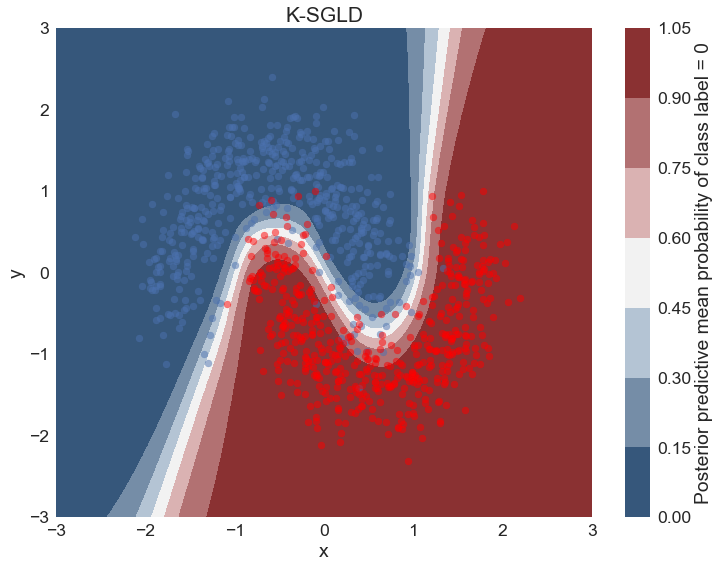

In [108]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.title('K-SGLD')

Text(0.5,1,'K-SGLD')

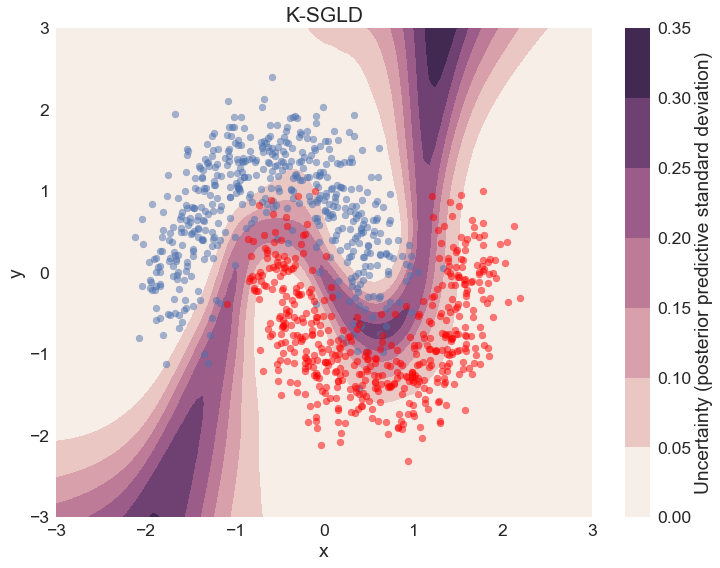

In [109]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1], alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='x', ylabel='y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');
plt.title('K-SGLD')